First we import the data from github and create a copy of the data which we will use for analysis(remove NAN values). We want a copy of the original data so we can impute values later.

In [1]:
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

url = "https://raw.githubusercontent.com/ErkCurley/Eric_ML/master/Assignment%204/Universities.csv"
data = pd.read_csv(url)

unis = data


Next we can view the column names, which will make it easier to drop specific columns for the analysis

In [2]:
for col in unis.columns: 
    print(col) 

College Name
State
Public (1)/ Private (2)
# appli. rec'd
# appl. accepted
# new stud. enrolled
% new stud. from top 10%
% new stud. from top 25%
# FT undergrad
# PT undergrad
in-state tuition
out-of-state tuition
room
board
add. fees
estim. book costs
estim. personal $
% fac. w/PHD
stud./fac. ratio
Graduation rate


Here we can see that College Name, State, and Public/Private are all non-continuous datatypes

In [3]:
unis.dtypes

College Name                 object
State                        object
Public (1)/ Private (2)       int64
# appli. rec'd              float64
# appl. accepted            float64
# new stud. enrolled        float64
% new stud. from top 10%    float64
% new stud. from top 25%    float64
# FT undergrad              float64
# PT undergrad              float64
in-state tuition            float64
out-of-state tuition        float64
room                        float64
board                       float64
add. fees                   float64
estim. book costs           float64
estim. personal $           float64
% fac. w/PHD                float64
stud./fac. ratio            float64
Graduation rate             float64
dtype: object

In [4]:
unis

,College Name,State,Public (1)/ Private (2),# appli. rec'd,# appl. accepted,# new stud. enrolled,% new stud. from top 10%,% new stud. from top 25%,# FT undergrad,# PT undergrad,in-state tuition,out-of-state tuition,room,board,add. fees,estim. book costs,estim. personal $,% fac. w/PHD,stud./fac. ratio,Graduation rate
0,Alaska Pacific University,AK,2,193.0,146.0,55.0,16.0,44.0,249.0,869.0,7560.0,7560.0,1620.0,2500.0,130.0,800.0,1500.0,76.0,11.9,15.0
1,University of Alaska at Fairbanks,AK,1,1852.0,1427.0,928.0,NaN,NaN,3885.0,4519.0,1742.0,5226.0,1800.0,1790.0,155.0,650.0,2304.0,67.0,10.0,NaN
2,University of Alaska Southeast,AK,1,146.0,117.0,89.0,4.0,24.0,492.0,1849.0,1742.0,5226.0,2514.0,2250.0,34.0,500.0,1162.0,39.0,9.5,39.0
3,University of Alaska at Anchorage,AK,1,2065.0,1598.0,1162.0,NaN,NaN,6209.0,10537.0,1742.0,5226.0,2600.0,2520.0,114.0,580.0,1260.0,48.0,13.7,NaN
4,Alabama Agri. & Mech. Univ.,AL,1,2817.0,1920.0,984.0,NaN,NaN,3958.0,305.0,1700.0,3400.0,1108.0,1442.0,155.0,500.0,850.0,53.0,14.3,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,West Virginia State College,WV,1,1869.0,NaN,957.0,NaN,NaN,2817.0,1939.0,1988.0,4616.0,1500.0,1700.0,50.0,750.0,750.0,38.0,19.2,NaN
1298,West Virginia University,WV,1,9630.0,7801.0,2881.0,23.0,49.0,14524.0,1053.0,2128.0,6370.0,2284.0,2026.0,NaN,NaN,NaN,83.0,13.4,57.0
1299,West Virginia Wesleyan College,WV,2,1566.0,1400.0,483.0,28.0,55.0,1509.0,170.0,14200.0,14200.0,1750.0,2025.0,NaN,450.0,1100.0,58.0,16.4,67.0
1300,Wheeling Jesuit College,WV,2,903.0,755.0,213.0,15.0,49.0,971.0,305.0,10500.0,10500.0,2100.0,2445.0,NaN,600.0,600.0,66.0,14.1,72.0


It's quite simple to drop all rows with NAN values

In [5]:
unis = unis.dropna()

Next we have a list of columns to normalize. I'm using a lambda function to map the values from 0-1

In [6]:
cols_to_norm = [
"# appli. rec'd",
"# appl. accepted",
"# new stud. enrolled",
"% new stud. from top 10%",
"% new stud. from top 25%",
"# FT undergrad",
"# PT undergrad",
"in-state tuition",
"out-of-state tuition",
"room",
"board",
"add. fees",
"estim. book costs",
"estim. personal $",
"% fac. w/PHD",
"stud./fac. ratio",
"Graduation rate"]

unis[cols_to_norm] = unis[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [7]:
unis

,College Name,State,Public (1)/ Private (2),# appli. rec'd,# appl. accepted,# new stud. enrolled,% new stud. from top 10%,% new stud. from top 25%,# FT undergrad,# PT undergrad,in-state tuition,out-of-state tuition,room,board,add. fees,estim. book costs,estim. personal $,% fac. w/PHD,stud./fac. ratio,Graduation rate
0,Alaska Pacific University,AK,2,0.002416,0.003236,0.004399,0.157895,0.384615,0.000000,0.039753,0.356659,0.341940,0.234674,0.491022,0.037071,0.315556,0.190840,0.715789,0.347490,0.000000
2,University of Alaska Southeast,AK,1,0.001437,0.002132,0.009741,0.031579,0.164835,0.007740,0.084635,0.058178,0.219458,0.448755,0.428678,0.007414,0.182222,0.139237,0.326316,0.254826,0.233010
9,Birmingham-Southern College,AL,2,0.015161,0.020062,0.040848,0.694737,0.868132,0.035899,0.009434,0.567002,0.557095,0.337644,0.473566,0.033982,0.137778,0.099237,0.694737,0.428571,0.553398
11,Huntingdon College,AL,2,0.011059,0.017473,0.015711,0.263158,0.417582,0.009206,0.005725,0.383337,0.369228,0.177203,0.500998,0.027804,0.182222,0.129771,0.578947,0.328185,0.281553
21,Talladega College,AL,2,0.090322,0.054779,0.048390,0.305263,0.560440,0.020991,0.005404,0.259491,0.242548,0.187739,0.251621,0.126043,0.404444,0.175573,0.505263,0.486486,0.300971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,Univ. of Wisconsin at Eau Claire,WI,1,0.117708,0.169744,0.303221,0.200000,0.472527,0.263331,0.057843,0.082085,0.312343,0.221504,0.151870,0.327464,0.084000,0.154198,0.757895,0.633205,0.446602
1283,Wisconsin Lutheran College,WI,2,0.001562,0.002551,0.007541,0.168421,0.351648,0.001051,0.000962,0.435666,0.422754,0.277778,0.341397,0.024714,0.182222,0.175573,0.421053,0.216216,0.339806
1284,Alderson-Broaddus College,WV,2,0.010517,0.016636,0.022781,0.210526,0.384615,0.017519,0.003526,0.505849,0.494542,0.223659,0.317955,0.025332,0.253333,0.236641,0.336842,0.332046,0.359223
1291,Marshall University,WV,2,0.086407,0.137234,0.311076,0.136842,0.560440,0.237434,0.107076,0.053971,0.212531,0.332854,0.361347,0.098857,0.271111,0.200000,0.726316,0.528958,0.339806


Next we can take a look at the relationship between two of the variables. To see if the mapping has worked correctly.

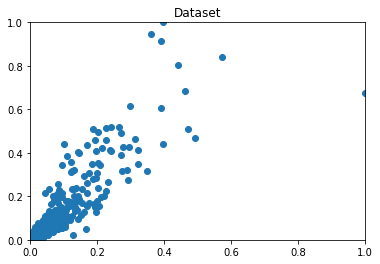

In [8]:
plt.plot() 
plt.xlim([0, 1]) 
plt.ylim([0, 1]) 
plt.title('Dataset') 
plt.scatter(unis['# appl. accepted'], unis['# FT undergrad']) 
plt.show() 




Next we can plot the relationship between all combinations of two variables. This should show some interesting trends in the data but is not neccessary for a classification algorithm such as kmeans.

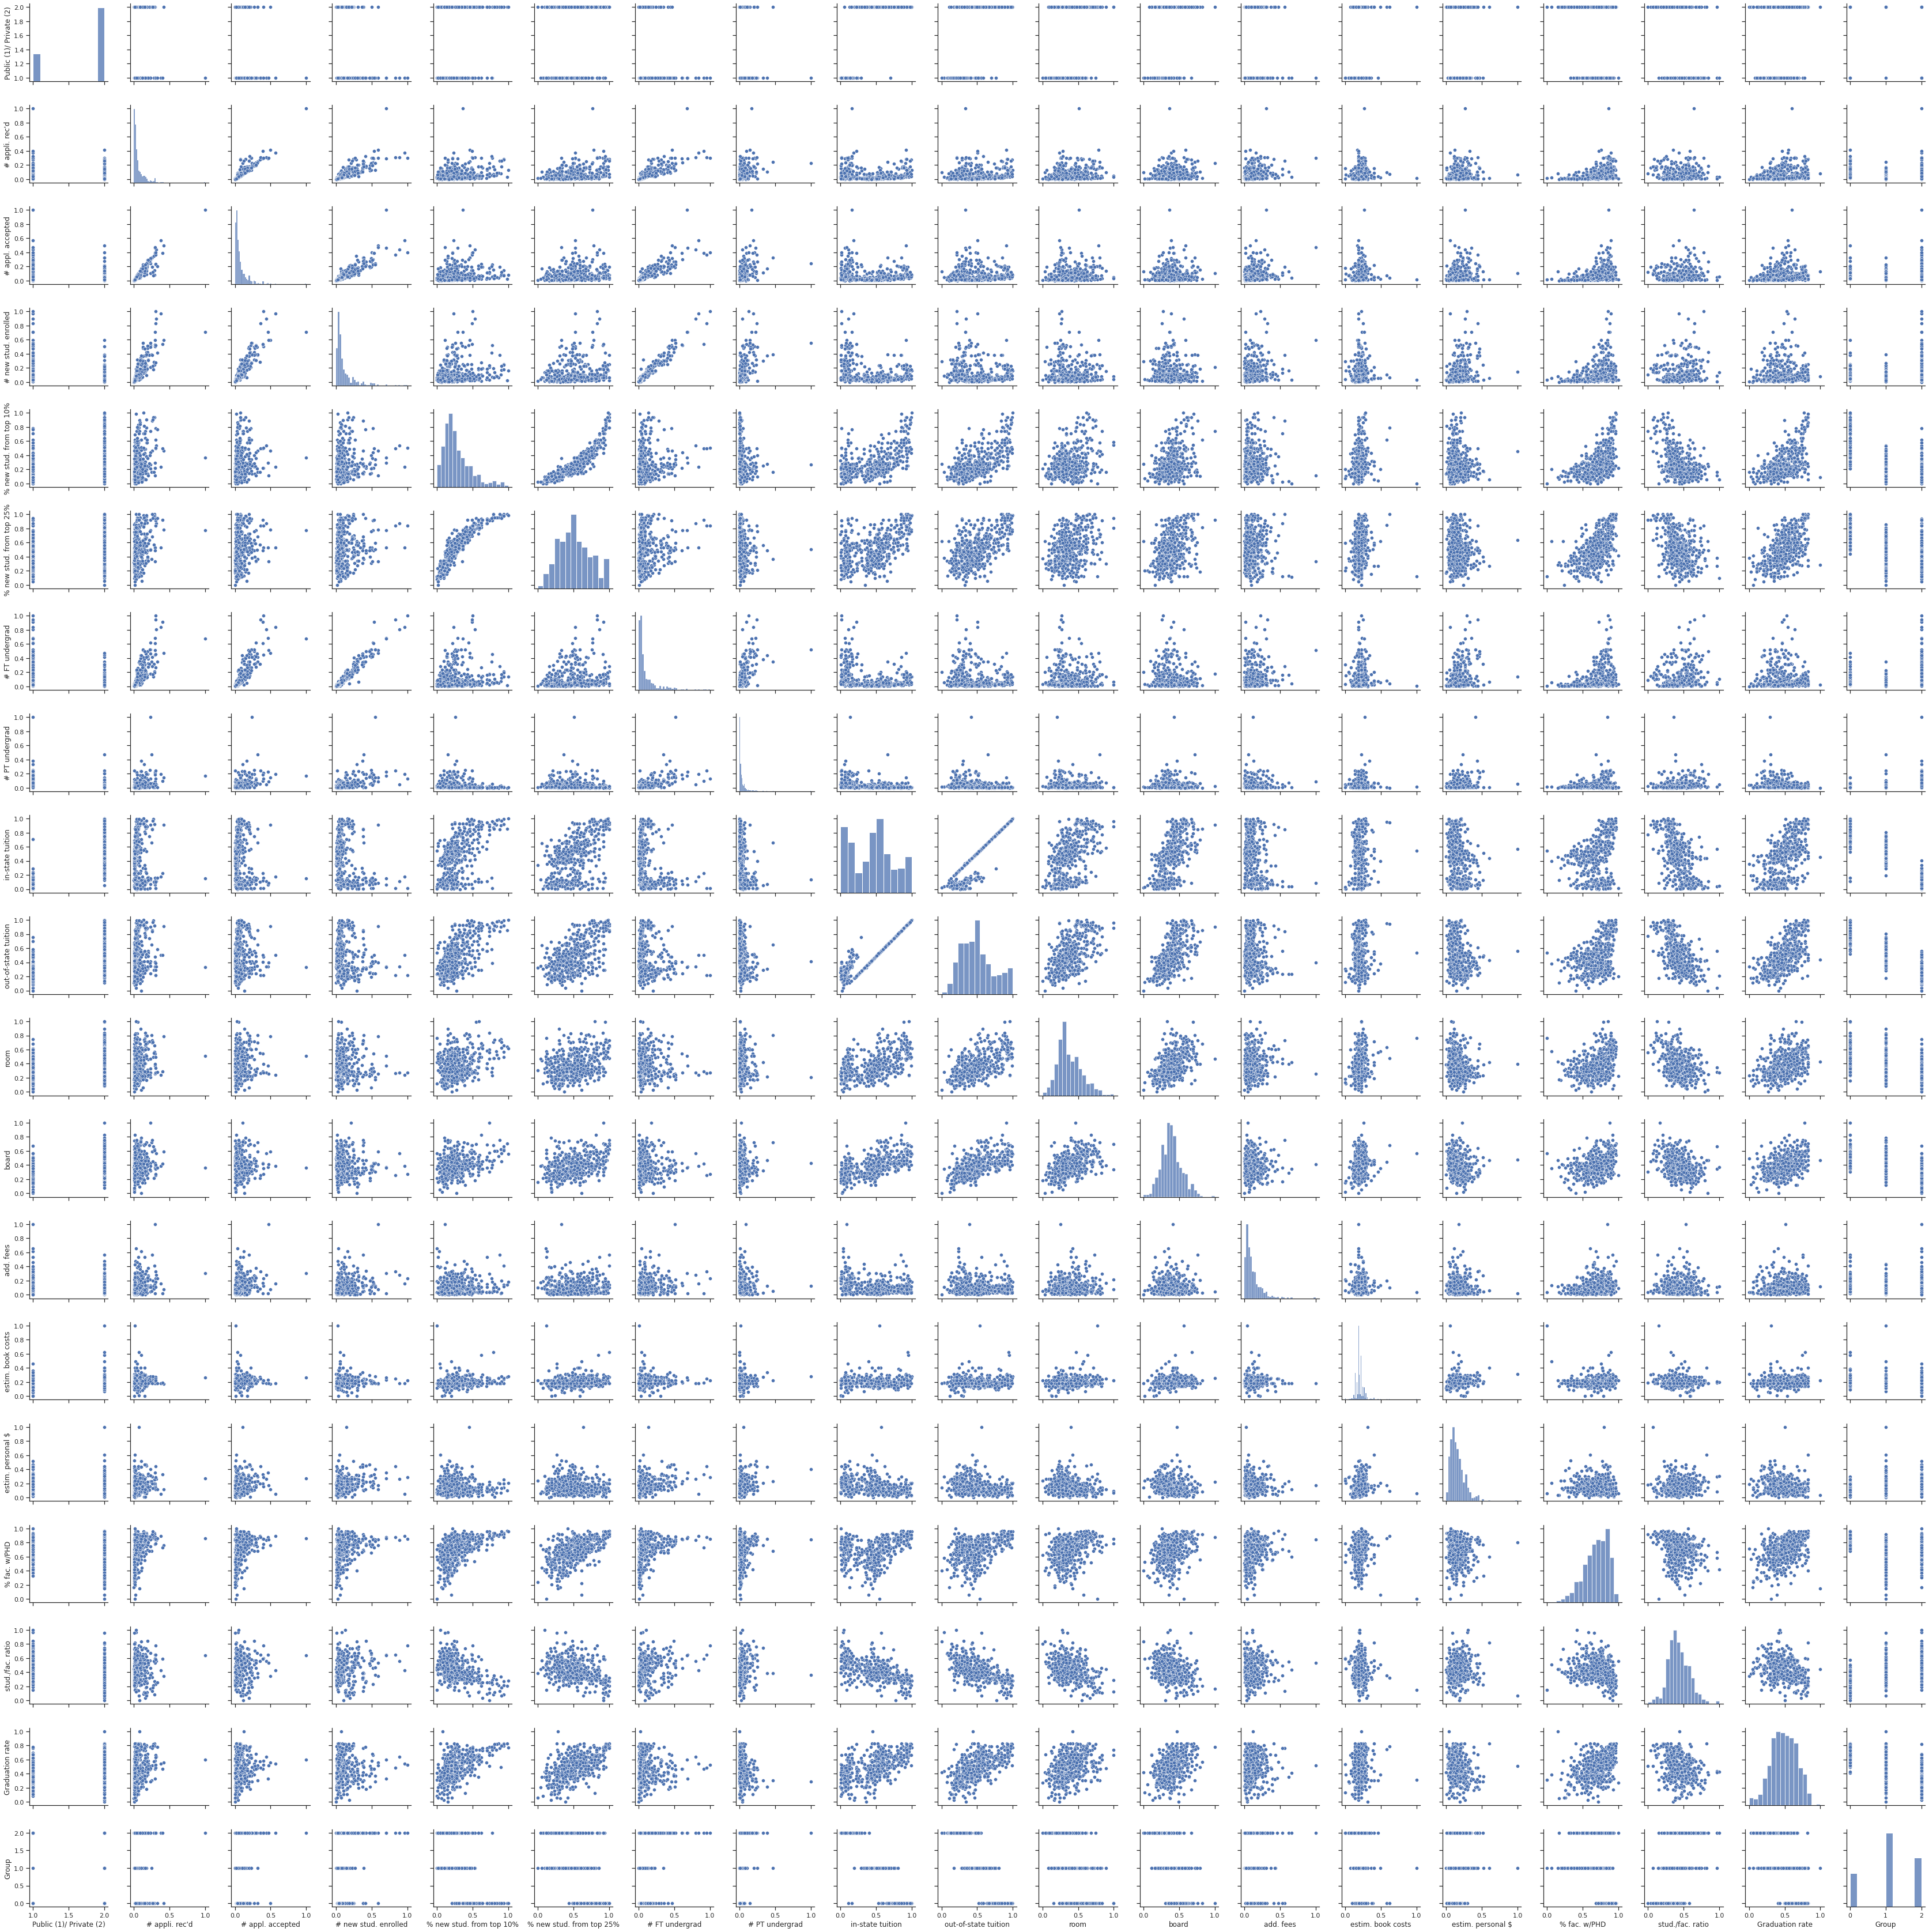

In [37]:
import seaborn as sns
sns.set_theme(style="ticks")

sns.pairplot(unis)

Next we must drop all the non-continuous values from the data to perform the kmeans clustering.

In [10]:
X = unis.drop(['College Name', 'State', 'Public (1)/ Private (2)'], axis=1).to_numpy()

kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
kmeans.cluster_centers_

array([[0.06732781, 0.07224437, 0.09557747, 0.43684211, 0.6839712 ,
        0.07263523, 0.01753801, 0.73597627, 0.73515296, 0.48018095,
        0.49383151, 0.1068234 , 0.20526437, 0.12161183, 0.80084694,
        0.3312475 , 0.62108024],
       [0.06195842, 0.07853299, 0.13179292, 0.19500266, 0.41229141,
        0.12484864, 0.04757105, 0.28467416, 0.36249671, 0.31911629,
        0.3398633 , 0.11820605, 0.20310662, 0.18586527, 0.61935141,
        0.48330148, 0.41463175]])

Next we need to identify the ideal number of clusters to choose for our analysis. I chose to use the elbow method becuase I have no apriori assumptions about the number of clusers.

In [11]:
distortions = [] 
inertias = [] 

K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_)

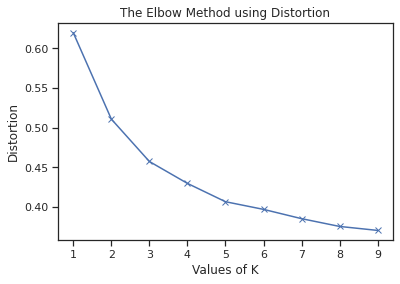

In [12]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

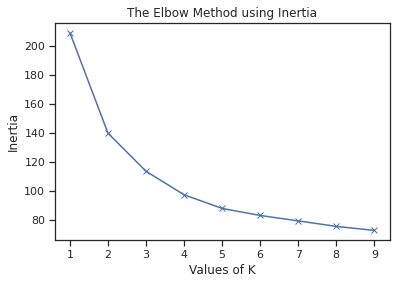

In [13]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

The elbow is a little difficult to tell where the ideal number of clusters is, I chose three as the number of clusers going forward.

In [14]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
centers = kmeans.cluster_centers_

Next we can display the center of each cluster for each of the variables.

The following is the summary of the 3 clusters:

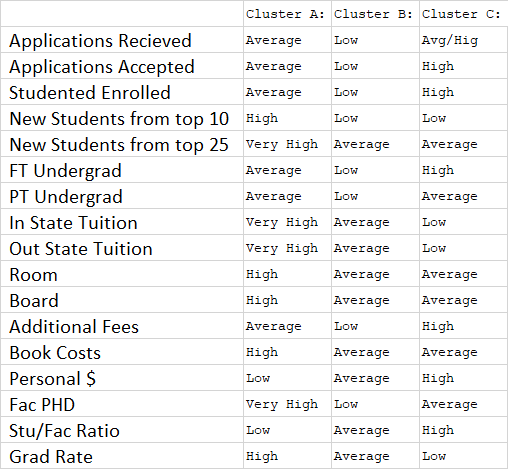

In [15]:
column_names = ["Name", "Cluster A", "Cluster B", "Cluster C"]

df = pd.DataFrame(columns = column_names)

indexNum = 0
for i in cols_to_norm:
  output = [i]
  for j in centers:
    output.append(round(j[indexNum],5))
  indexNum = indexNum + 1
  # df.append(pd.DataFrame(output,columns=column_names))
  print(output)

["# appli. rec'd", 0.08805, 0.02615, 0.10418]
['# appl. accepted', 0.08569, 0.03654, 0.12924]
['# new stud. enrolled', 0.11142, 0.05278, 0.22163]
['% new stud. from top 10%', 0.54528, 0.22257, 0.19893]
['% new stud. from top 25%', 0.78022, 0.44733, 0.42805]
['# FT undergrad', 0.08459, 0.03854, 0.2204]
['# PT undergrad', 0.01072, 0.02139, 0.07669]
['in-state tuition', 0.82616, 0.50799, 0.11076]
['out-of-state tuition', 0.83123, 0.49884, 0.27622]
['room', 0.52655, 0.36115, 0.30387]
['board', 0.50856, 0.40779, 0.30387]
['add. fees', 0.11758, 0.07936, 0.16353]
['estim. book costs', 0.21552, 0.19818, 0.20456]
['estim. personal $', 0.10996, 0.15507, 0.20831]
['% fac. w/PHD', 0.85336, 0.60612, 0.69289]
['stud./fac. ratio', 0.29607, 0.40961, 0.54284]
['Graduation rate', 0.66481, 0.48592, 0.37969]


We can now make a prediction/classification for each record individually

In [16]:
Y = []
for x in X:
  Y.append(kmeans.predict(x.reshape(1,-1)))

Y[0]

array([1], dtype=int32)

In [17]:
Y = kmeans.predict(X)
Y

array([1, 2, 0, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 2, 0, 2, 2, 2, 2, 2, 0, 1, 1, 0, 1, 1, 0, 2, 2, 1,
       0, 0, 1, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 0, 1, 1, 2, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 2, 1, 1, 0, 2, 2, 2, 1, 0, 0, 0, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 2, 2, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 2, 2, 2, 2, 0, 1, 2, 0, 0, 0,
       0, 0, 2, 2, 2, 0, 0, 2, 1, 2, 1, 0, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2,
       1, 0, 1, 1, 1, 1, 0, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1,
       0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 0, 2, 1, 2, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1,
       2, 2, 2, 0, 1, 1, 2, 2, 1, 0, 1, 2, 1, 2, 2, 0, 2, 1, 1, 2, 2, 2,
       1, 2, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,

And we can add the classification back to our data.

In [18]:
unis['Group'] = Y
unis

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,College Name,State,Public (1)/ Private (2),# appli. rec'd,# appl. accepted,# new stud. enrolled,% new stud. from top 10%,% new stud. from top 25%,# FT undergrad,# PT undergrad,in-state tuition,out-of-state tuition,room,board,add. fees,estim. book costs,estim. personal $,% fac. w/PHD,stud./fac. ratio,Graduation rate,Group
0,Alaska Pacific University,AK,2,0.002416,0.003236,0.004399,0.157895,0.384615,0.000000,0.039753,0.356659,0.341940,0.234674,0.491022,0.037071,0.315556,0.190840,0.715789,0.347490,0.000000,1
2,University of Alaska Southeast,AK,1,0.001437,0.002132,0.009741,0.031579,0.164835,0.007740,0.084635,0.058178,0.219458,0.448755,0.428678,0.007414,0.182222,0.139237,0.326316,0.254826,0.233010,2
9,Birmingham-Southern College,AL,2,0.015161,0.020062,0.040848,0.694737,0.868132,0.035899,0.009434,0.567002,0.557095,0.337644,0.473566,0.033982,0.137778,0.099237,0.694737,0.428571,0.553398,0
11,Huntingdon College,AL,2,0.011059,0.017473,0.015711,0.263158,0.417582,0.009206,0.005725,0.383337,0.369228,0.177203,0.500998,0.027804,0.182222,0.129771,0.578947,0.328185,0.281553,1
21,Talladega College,AL,2,0.090322,0.054779,0.048390,0.305263,0.560440,0.020991,0.005404,0.259491,0.242548,0.187739,0.251621,0.126043,0.404444,0.175573,0.505263,0.486486,0.300971,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,Univ. of Wisconsin at Eau Claire,WI,1,0.117708,0.169744,0.303221,0.200000,0.472527,0.263331,0.057843,0.082085,0.312343,0.221504,0.151870,0.327464,0.084000,0.154198,0.757895,0.633205,0.446602,2
1283,Wisconsin Lutheran College,WI,2,0.001562,0.002551,0.007541,0.168421,0.351648,0.001051,0.000962,0.435666,0.422754,0.277778,0.341397,0.024714,0.182222,0.175573,0.421053,0.216216,0.339806,1
1284,Alderson-Broaddus College,WV,2,0.010517,0.016636,0.022781,0.210526,0.384615,0.017519,0.003526,0.505849,0.494542,0.223659,0.317955,0.025332,0.253333,0.236641,0.336842,0.332046,0.359223,1
1291,Marshall University,WV,2,0.086407,0.137234,0.311076,0.136842,0.560440,0.237434,0.107076,0.053971,0.212531,0.332854,0.361347,0.098857,0.271111,0.200000,0.726316,0.528958,0.339806,2


We can also plot the count of unis per state.

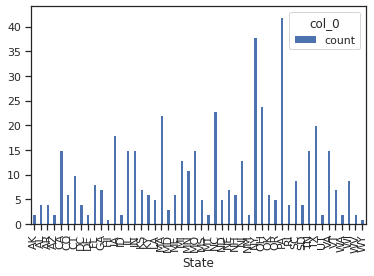

In [19]:
my_tab = pd.crosstab(index = unis['State'],  # Make a crosstab
                              columns="count")      # Name the count column

my_tab.plot.bar()

We can also count the number of unis in each group at the state level.

In [20]:
unis_table = pd.crosstab(index=unis["State"], 
                          columns=unis["Group"])
unis_table

Group,0,1,2
State,,,
AK,0,1,1
AL,1,1,2
AR,0,3,1
AZ,0,0,2
CA,10,4,1
CO,1,0,5
CT,3,4,3
DC,2,2,0
DE,0,1,1


This plot shows the count of universities in each state based on their group classification.

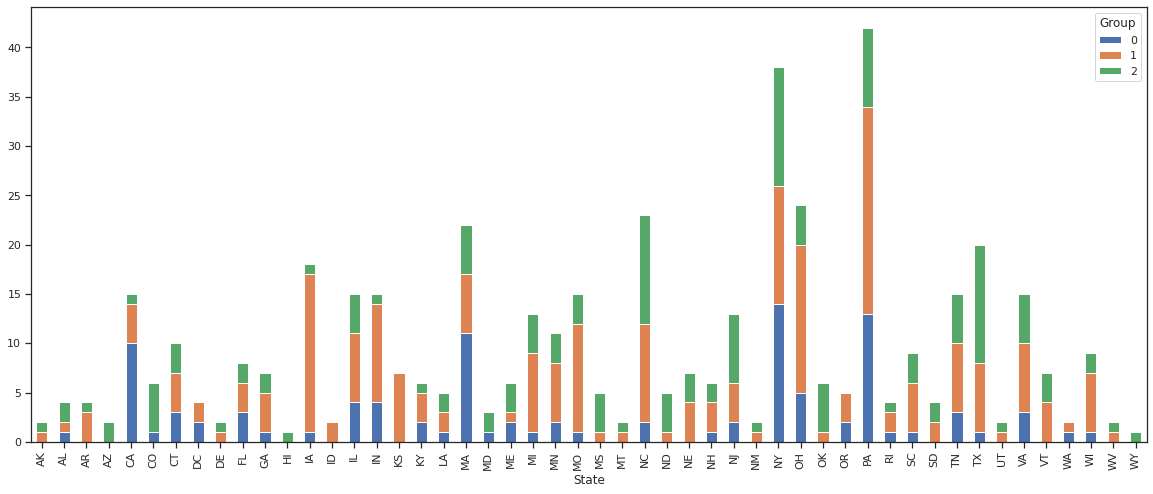

In [21]:
unis_table.plot(kind="bar", 
                 figsize=(20,8),
                 stacked=True)

We can also plot the same but with the public vs private categories.

In [22]:
unis_table1 = pd.crosstab(index=unis["Public (1)/ Private (2)"], 
                          columns=unis["Group"])
unis_table1

Group,0,1,2
Public (1)/ Private (2),,,
1,3,1,124
2,98,221,24


Here we can see that Group 2 mostly represents public schools, where as group 0 and 1 represent different classifications of private schools. Some private schools also fall into group 2 classification, this could be because of how they treat things like room and board expenses, or other factors which would make them more similar to public schools.

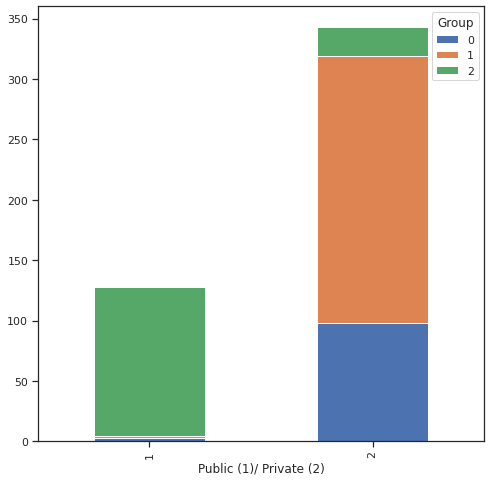

In [23]:
unis_table1.plot(kind="bar", 
                 figsize=(8,8),
                 stacked=True)

Finally I selected the indicated university "Tufts University" from the original data. This had to be done from the original data because the record was removed with all the other NAN values.

In [24]:
data.rename(columns={"College Name": "CollegeName"})

data[data['College Name'].str.startswith(('tu','Tu'))]

Tufts = data[data['College Name'] == 'Tufts University']

Tufts

,College Name,State,Public (1)/ Private (2),# appli. rec'd,# appl. accepted,# new stud. enrolled,% new stud. from top 10%,% new stud. from top 25%,# FT undergrad,# PT undergrad,in-state tuition,out-of-state tuition,room,board,add. fees,estim. book costs,estim. personal $,% fac. w/PHD,stud./fac. ratio,Graduation rate
475,Tufts University,MA,2,7614.0,3605.0,1205.0,60.0,90.0,4598.0,NaN,19701.0,19701.0,3038.0,2930.0,503.0,600.0,928.0,99.0,10.3,92.0


Here I calculated the distance that tufts has from the centers of the categories. I had to removed the NAN column from tufts and the corresponding column from the center measures so that the distance could be calculated.

In [25]:
from sklearn.metrics.pairwise import euclidean_distances

temp = Tufts.drop(['College Name', 'State', 'Public (1)/ Private (2)', '# PT undergrad'], axis=1)
tempCenters = []

for i, v in enumerate(centers):
  tempCenters.append([])
  for x, z in enumerate(v):
    if x != 6:
      tempCenters[i].append(z)

euclidean_distances(temp,tempCenters)

array([[29817.18449044, 29817.67484322, 29818.03132179]])

Lastly, the centroid for category 1 AKA [0] was the closest to Tufts thus I assigned the missing value the corresponding value from that centroid and confirmed the prediction

In [36]:
Tufts['# PT undergrad'] = centers[0][6]

temp = Tufts.drop(['College Name', 'State', 'Public (1)/ Private (2)'], axis=1)

kmeans.predict(temp)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


array([0], dtype=int32)

The original data was updated with the new and improved data for Tufts.

In [32]:

data.update(Tufts)

data[data['College Name'] == 'Tufts University']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,College Name,State,Public (1)/ Private (2),# appli. rec'd,# appl. accepted,# new stud. enrolled,% new stud. from top 10%,% new stud. from top 25%,# FT undergrad,# PT undergrad,in-state tuition,out-of-state tuition,room,board,add. fees,estim. book costs,estim. personal $,% fac. w/PHD,stud./fac. ratio,Graduation rate
475,Tufts University,MA,2.0,7614.0,3605.0,1205.0,60.0,90.0,4598.0,0.010719,19701.0,19701.0,3038.0,2930.0,503.0,600.0,928.0,99.0,10.3,92.0
